### Description

This notebooks collects the datasets downloaded from the ClinVar webpage (https://ftp.ncbi.nlm.nih.gov/pub/clinvar/tab_delimited/) into one dataset to retrive the changed labels (notebook 1.ClinVar Analysis)


In [4]:
import pandas as pd
import os
from glob import glob
os.chdir('/fast/groups/ag_kircher/work/MisLa/MisLaReview')# run only once, or change to hard coded path


In [241]:
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import numpy as np
import sys
os.chdir('/fast/groups/ag_kircher/work/MisLa/MisLaReview/scripts')# run only once, or change to hard coded path
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('max_colwidth', None)


sys.path.insert(0,'scripts/')
from utilsClinVar import *
import matplotlib.style
import matplotlib as mpl
#mpl.style.use('classic')
#mpl.rcParams['image.cmap'] = 'jet'
os.chdir('/fast/groups/ag_kircher/work/MisLa/MisLaReview')# run only once, or change to hard coded path


In [20]:
# not all years have data for all months
years = [2015,2016,2017,2018,2019,2020,2021,2022,2023]  
# the ClinicalSignificance columns has various classes, take only these to avoid ambiguity 
classes = ['Uncertain significance', 'Likely benign', 'Benign', 'Conflicting interpretations of pathogenicity', 
           'Pathogenic', 'Likely pathogenic', 'Benign/Likely benign', 'Pathogenic/Likely pathogenic']

CHR = pd.Series(list(range(1,23))+['X','Y']).astype(str)

years = [2015]   
dates = []
di = {'Ref': ['ReferenceAllele', 'ReferenceAlleleVCF'],
                 'Alt' : ['AlternateAllele', 'AlternateAlleleVCF' ]}
allYears = pd.DataFrame()
for year in years:
    y = str(year)
    print(year)
    files = pd.Series(glob('dataRaw/ClinVar/'+y+'/*')).sort_values()[:]
    for file in files:
        df_temp = pd.read_csv(file,sep = '\t',low_memory=False, na_values = ['na'])
        
        # some months in 2015 does not have any allele column: ignore them 
        if not sum(df_temp.columns.str.contains('ReferenceAllele')):
            print(file)
            pass 
        else:
            
            d = file.split('_')[2].split('.')[0]
            dates.append(d)

            df_temp = df_temp[df_temp['Type']=='single nucleotide variant']
            df_temp = df_temp[df_temp['Assembly']=='GRCh38']
            df_temp = df_temp[df_temp['ClinicalSignificance'].isin(classes)]
            
           
            
            for key in di.keys():
            
                df_temp[key] = df_temp[di[key][0]]
                
                ind = df_temp[df_temp[key].isna()].index
                # from end of 2020, the ReferenceAllele and AlternateAllele are not used anymore
                # but columns ReferenceAlleleVCF and AlternateAlleleVCF
                if sum(df_temp.columns.str.contains(di[key][1])):

                    df_temp.loc[ind, key] = df_temp.loc[ind, di[key][1]]
                    
            s = len(df_temp)

            cols = ['Chromosome', 'Start', 'Ref', 'Alt']
            df_temp = df_temp.dropna(subset = cols, how = 'any')
            
            df_temp = df_temp[((df_temp['Ref'].isin(['A', 'T', 'C', 'G']))&(df_temp['Alt'].isin(['A', 'T', 'C', 'G'])))]
            df_temp = df_temp[df_temp['Chromosome'].astype(str).isin(CHR)]
            df_temp['Start'] = df_temp['Start'].astype(int)

            df_temp = df_temp.drop_duplicates(cols)
            print('{}: Length of the joint file is : {}, {} less than the original'.format(d,len(df_temp),s-len(df_temp)))
            df_temp = df_temp.set_index(cols, drop = False)
            allYears = pd.concat([allYears, df_temp['ClinicalSignificance']],axis = 1, join = 'outer')

allYears.columns = dates
# unique keeps the order of the labels occurance
uniqueLabels = allYears.T.apply(lambda x: x.dropna().unique())
allYears['uniqueLabels'] = uniqueLabels
allYears['LabelOld'] = allYears['uniqueLabels'].str[0]
allYears['LabelNew'] = allYears['uniqueLabels'].str[-1]
labels = ['LabelOld', 'LabelNew']


to_replace = {'Uncertain significance': 'VUS', 
              'Conflicting interpretations':'Conflicting',
             'Pathogenic/Likely pathogenic': 'Pathogenic',
             'Likely pathogenic' :'Pathogenic',
             'Benign/likely benign' : 'Benign',
             'Likely benign' :'Bengn'}
allYears[labels] = allYears[labels].replace(to_replace)



changed = (allYears['LabelOld']!=allYears['LabelNew']).sum()
print('The final file has {} entries. {} variants changed their clinical interpretation.'.format(len(allYears),changed ))



#allYears.to_csv('dataProduced/ClinVarAllLabels.csv.gz',index = True, header = True,
#                sep='\t', compression = 'zip' )

#allYears.to_csv('dataProduced/ClinVarTwoLabels.csv.gz',index = True, header = True,
#                sep='\t', compression = 'zip' )

2015
dataRaw/ClinVar/2015/variant_summary_2015-02.txt.gz
dataRaw/ClinVar/2015/variant_summary_2015-03.txt.gz
dataRaw/ClinVar/2015/variant_summary_2015-04.txt.gz
2015-05: Length of the joint file is : 80445, 413 less than the original
2015-06: Length of the joint file is : 81441, 416 less than the original
2015-07: Length of the joint file is : 82097, 415 less than the original
2015-08: Length of the joint file is : 67048, 581 less than the original
2015-09: Length of the joint file is : 70294, 406 less than the original
2015-10: Length of the joint file is : 71319, 383 less than the original
2015-11: Length of the joint file is : 77264, 401 less than the original
2015-12: Length of the joint file is : 77654, 408 less than the original
The final file has 102452 entries. 186 variants changed their clinical interpretation.


In [79]:
allYears = pd.read_csv('dataProduced/ClinVarTwoLabels.csv.gz', sep = '\t', compression = 'zip') 
allYears

/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_1988812/2747890801.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  allYears = pd.read_csv('dataProduced/ClinVarTwoLabels.csv.gz', sep = '\t', compression = 'zip')


,Chromosome,Start,Ref,Alt,LabelOld,LabelNew
0,1,925952,G,A,VUS,VUS
1,1,925956,C,T,Bengn,Bengn
2,1,925969,C,T,Bengn,Bengn
3,1,925976,T,C,VUS,VUS
4,1,925986,C,T,Bengn,Bengn
...,...,...,...,...,...,...
1430395,Y,57126292,T,C,Bengn,Bengn
1430396,Y,57190090,G,A,Benign,Benign
1430397,Y,57191079,C,T,Benign,Benign
1430398,Y,57196354,G,A,Benign,Benign


#### Create VCF vor annotating the variants

In [83]:
allYears = allYears.iloc[:100,0:4]


In [ ]:
/fast/work/groups/ag_kircher/CADD/projects/genome16/whole_genome_GRCh38/all_SNV_inclAnno.tsv.gz

In [ ]:
for 

In [81]:
allYears
# sort -k1,1 -k2,2n -k3,3 -k4,4
cols = ['Chromosome', 'Start', 'Ref', 'Alt']

allYears.sort_values(cols)

,Chromosome,Start,Ref,Alt,LabelOld,LabelNew
0,1,925952,G,A,VUS,VUS
1,1,925956,C,T,Bengn,Bengn
2,1,925969,C,T,Bengn,Bengn
3,1,925976,T,C,VUS,VUS
4,1,925986,C,T,Bengn,Bengn
...,...,...,...,...,...,...
1430395,Y,57126292,T,C,Bengn,Bengn
1430396,Y,57190090,G,A,Benign,Benign
1430397,Y,57191079,C,T,Benign,Benign
1430398,Y,57196354,G,A,Benign,Benign


awk 'BEGIN{ OFS="\t"} NR==FNR{ a[$1 FS $2 FS $3 FS $4];next} ($1 FS $2 FS $3 FS $4) in a {print $1, $2, $3} ' <(zcat output/predictions/lifted/new/hg38.predictions.lifted.txt.gz) <(zcat input/variants/hg19/ReMM.v0.3.1.tsv.gz) |gzip -c  > output/predictions/lifted/new/SNVs.lifted.remm.txt.gz;

In [86]:
cols = ['Chromosome', 'Start', 'Ref', 'Alt']

vcf = allYears[cols]
vcf.columns = ["#CHROM",'POS','REF','ALT']

vcf[['ID', 'QUAL','FILTER','INFO']] = '.'
vcf.columns = ["#CHROM",'POS','ID','REF','ALT','QUAL','FILTER','INFO']

string = '##fileformat=VCFv4.1'
                    
cols = [string,'','','','','','','']
vcf = vcf.T.reset_index().T 
vcf.columns = cols
display(vcf)
file = 'test.vcf'

vcf.to_csv(file, sep = '\t', index = None,
         #  compression = 'bz2'
          ) 


,##fileformat=VCFv4.1,,,,,,,
index,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO
0,1,925952,G,A,.,.,.,.
1,1,925956,C,T,.,.,.,.
2,1,925969,C,T,.,.,.,.
3,1,925976,T,C,.,.,.,.
...,...,...,...,...,...,...,...,...
95,1,935779,G,A,.,.,.,.
96,1,935788,C,T,.,.,.,.
97,1,935792,C,G,.,.,.,.
98,1,935793,C,T,.,.,.,.


In [39]:
vcf.head()

,##fileformat=VCFv4.1,,,,,,,
index,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO
0,1,1014143,C,T,.,.,.,.
1,1,1014359,G,T,.,.,.,.
2,1,1020217,G,T,.,.,.,.
3,1,1020239,G,C,.,.,.,.


### Short analysis (need to run only from here on, all data is read in)

#### Changes of CS over the monthes

In [3]:
import sys
sys.path.insert(0, '../utils/')
from utils import *
import os
os.getcwd()

'/fast/work/groups/ag_kircher/MisLa/MisLaProject'

In [190]:
## Count the occurancies of changes (ind) over all months and years: (tn - tn+1)
ind = ['Benign-Pathogenic', 'Benign-VUS',
       'Pathogenic-Benign', 'Pathogenic-VUS',
       'VUS-Benign', 'VUS-Pathogenic',
      'Conflicting-Benign','Conflicting-Pathogenic',
       'Conflicting-VUS','VUS-Conflicting',
      'Pathogenic-Conflicting','Benigh-Conflicting']
ind = ['Benign-Conflicting', 'Benign-Pathogenic',
       'Benign-VUS', 'Conflicting-Benign', 'Conflicting-Pathogenic',
       'Conflicting-VUS', 'Pathogenic-Benign', 'Pathogenic-Conflicting',
       'Pathogenic-VUS', 'VUS-Benign', 'VUS-Conflicting', 'VUS-Pathogenic']
allValues = pd.DataFrame(index = ind)
n = f.shape[1]
#display(allValues)
for col in range(0, n-1):
    values = []
    names = []
    table = pd.crosstab(f.iloc[:,col],f.iloc[:,col+1],normalize = False)
   # display(table)
    for i in range(len(table)):
        for j in range(len(table)):
            if i!=j:
                name = table.index[i] + '-' + table.columns[j]
                value = table.iloc[i,j]
                names.append(name)
                values.append(value)
    df = pd.DataFrame(values,names)
    df.columns = [f.iloc[:,col].name]
  
    allValues = allValues.join(df, how = 'outer')
    
#allValues = allValues/allValues.sum()
#allValues.columns = dates[1:]

In [191]:
allValues

,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03
Benign-Conflicting,0,0,1,5,0,5,1,1,5,1,1,2,2,2,1,4,1,3,1,0,6,1,9,8,2,87,363,112,23,6,147,122,72,14,474,12,27,788,127,265,0,304,129,40,366,132,444,10,46,86,61,363,5,31,303,17,7,0,1,920,87,333,414,6083,250,499,37,17,57,14,11,156,52,765
Benign-Pathogenic,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,7,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,6,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0
Benign-VUS,42,7,79,3,28,230,17,0,166,7,18,35,6,3,3,89,111,102,1,77,48,19,2704,127,5,18,1,0,1,0,14,3,0,4,12,0,0,3,1,11,0,9,6,2,3,1,2,1,0,4,12,5,1,0,3,0,0,0,1,9,2,1,14,701,12,18,5,0,0,0,2,7,3,24
Conflicting-Benign,0,0,0,7,0,2,0,0,0,0,11,1,0,0,2,1,0,24,0,0,12,1,1,0,1,1,37,2,2,106,2,0,2,135,93,1,11,123,123,711,4,9,1,73,5,42,83,13,2,16,0,4,1,20,349,5,409,0,230,71,78,148,148,2442,161,677,11,4,6,3,83,215,5,47
Conflicting-Pathogenic,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,38,0,0,0,0,0,0,0,0,15,1,0,1,5,2,3,2,31,1,44,12,19,242,2,13,1,8,38,11,26,1,5,4,50,16,3,12,153,2,3,0,41,13,14,18,127,16,34,63,9,33,3,46,21,105,4,11
Conflicting-VUS,1,1,2,2,0,13,1,0,5,2,4,2,1,1,0,7,6,31,1,2,2,0,6,11,2,0,11,3,2,0,42,0,4,6,33,2,14,4,26,1229,0,35,1,7,9,12,2,5,8,4,52,25,1,10,25,5,2,0,11,20,7,4,26,37,22,126,5,1,4,10,6,9,5,5
Pathogenic-Benign,1,0,0,1,0,0,0,1,0,1,4,0,0,0,0,3,3,0,1,0,20,0,1,0,1,2,0,0,1,0,0,0,0,0,1,0,0,1,0,4,1,0,21,3,2,2,0,0,2,1,0,1,1,1,0,13,35,0,78,11,0,0,2,19,4,1,0,0,0,0,0,4,3,1
Pathogenic-Conflicting,8,0,2,4,5,31,1,0,5,0,2,2,1,0,0,4,22,4,0,38,1,0,109,2,0,73,192,40,13,0,63,42,51,9,338,2,28,163,151,155,4,61,224,60,215,27,32,2,36,32,18,214,16,121,249,19,7,1,50,163,18,42,272,165,137,412,86,13,44,49,13,38,18,423
Pathogenic-VUS,15,15,49,10,14,76,20,9,31,10,26,20,11,13,2,159,115,94,1,30,59,8,238,71,5,43,4,1,10,0,54,0,2,0,46,0,1,9,22,69,3,38,169,46,79,21,20,0,25,22,59,71,25,5,124,16,24,6,3,69,12,16,150,138,50,184,30,6,17,23,7,27,117,198
VUS-Benign,13,21,217,1,0,127,0,0,133,0,46,16,224,2,1,171,24,11,4,38,20,1,224,5,0,167,21,0,3,60,1,1,174,111,117,4,18,62,127,129,1,7,9,13,16,25,29,0,0,2,6,14,0,0,25,46,246,0,1078,33,20,48,328,3329,61,17,12,1,4,1,37,624,6,10


In [11]:
li = []
for col in f.columns:
    for l in list(f.loc[:,col].unique()):
        li.append(l)

In [14]:
allValues.sum(axis = 1).index

Index(['Benign-Conflicting', 'Benign-Pathogenic', 'Benign-VUS',
       'Conflicting-Benign', 'Conflicting-Pathogenic', 'Conflicting-VUS',
       'Pathogenic-Benign', 'Pathogenic-Conflicting', 'Pathogenic-VUS',
       'VUS-Benign', 'VUS-Conflicting', 'VUS-Pathogenic'],
      dtype='object')

In [147]:
## Count the occurancies of changes (ind) over all months and years: (tn - tn+1)
#ind = ['Benign-Pathogenic', 'Benign-VUS',
#       'Pathogenic-Benign', 'Pathogenic-VUS',
#       'VUS-Benign', 'VUS-Pathogenic',
#      'Conflicting-Benign','Conflicting-Pathogenic',
#       'Conflicting-VUS','VUS-Conflicting',
#      'Pathogenic-Conflicting','Benigh-Conflicting']
allValuesSample = pd.DataFrame(index = ind)
## TAKE onyk the onse that were present in the first year??
fSample = f[~f['2015-02'].isna()]
n = fSample.shape[1]

for col in range(0, n-1):
    values = []
    names = []
    table = pd.crosstab(fSample.iloc[:,col],fSample.iloc[:,col+1],normalize = False)
    for i in range(3):
        for j in range(3):
            if i!=j:
                name = table.index[i] + '-' + table.columns[j]
                value = table.iloc[i,j]
                names.append(name)
                values.append(value)
    df = pd.DataFrame(values,names)
    df.columns = [f.iloc[:,col].name]
  
    allValuesSample = allValuesSample.join(df, how = 'left')
    
#allValues = allValues/allValues.sum()
#allValues.columns = dates[1:]
allValuesSampleRel = allValuesSample/allValuesSample.sum()

# Value count of ClinicalSignificance in all data sets
classes = ['VUS','Conflicting','Pathogenic','Benign']
col = 'CS'
countSample = pd.DataFrame(index = classes)
#date = []
for col in f:
    d = fSample[col].value_counts(normalize = True)
    countSample = countSample.join(d, lsuffix ='', rsuffix = str(i),how = 'outer')
       # date.append(str(i+1)+ '-' +str(years[j]))
countSample.columns = dates
countSample = countSample.sort_values(countSample.columns[0],ascending = False)



In [146]:
allValuesSample.sum(axis = 1)

Benign-Conflicting        1987.0
Benign-Pathogenic           20.0
Benign-VUS                   0.0
Conflicting-Benign        2016.0
Conflicting-Pathogenic     571.0
Conflicting-VUS              0.0
Pathogenic-Benign          135.0
Pathogenic-Conflicting    1449.0
Pathogenic-VUS               0.0
VUS-Benign                   0.0
VUS-Conflicting              0.0
VUS-Pathogenic               0.0
dtype: float64

In [16]:
allValuesRel = allValues/allValues.sum()
allValuesRel.columns = allValuesRel.columns.str.replace('CS_','')

In [17]:
# Value count of ClinicalSignificance in all data sets
classes = ['VUS','Conflicting','Pathogenic','Benign']
col = 'CS'
count = pd.DataFrame(index = classes)
#date = []
for col in f:
    d = f[col].value_counts(normalize = True)
    count = count.join(d, lsuffix ='', rsuffix = str(i),how = 'outer')
       # date.append(str(i+1)+ '-' +str(years[j]))
count.columns = dates
count = count.sort_values(count.columns[0],ascending = False)


In [142]:
allValuesRel.sum(axis = 1)

Benign-Conflicting        10.823296
Benign-Pathogenic          0.318641
Benign-VUS                 8.308336
Conflicting-Benign         5.163500
Conflicting-Pathogenic     1.772827
Conflicting-VUS            2.049656
Pathogenic-Benign          0.700188
Pathogenic-Conflicting     6.364366
Pathogenic-VUS            10.274604
VUS-Benign                 7.802050
VUS-Conflicting           16.607907
VUS-Pathogenic             3.814628
dtype: float64

### Number of variants in the ClinVar DB 

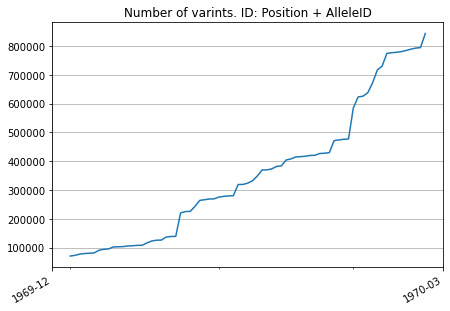

In [18]:
import matplotlib
#matplotlib.style.use('ggplot')

fig, ax = plt.subplots(figsize = (7,5))
ax.plot(st.index, st)
fmt_half_year = mdates.MonthLocator(interval=6)
ax.xaxis.set_major_locator(fmt_half_year)

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.format_xdata = mdates.DateFormatter('%Y-%m')
#ax.format_ydata = lambda x: f'${x:.2f}'  # Format the price.
ax.grid(True)

fig.autofmt_xdate()
title = 'Number of varints. ID: Position + AlleleID'
plt.title(title)
#plt.savefig('figures/'+ title + '.png')

plt.show()

In [234]:
import seaborn as sns
#sns.set_palette()
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [270]:
import seaborn as sns

sns.set_palette(
sns.color_palette("deep"))


In [249]:
sns.color_palette("colorblind")[:7]

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236)]

In [246]:
colors = ['gold','olivedrab','green','brown','darkgrey',
         'darkseagreen','steelblue']
sns.set_palette(colors)
#colors = ['8DBACB','A7CAD6','FFFFFF','C2297A','BF2175']
#sns.set_palette(colors)


In [269]:
sns.color_palette("deep")


[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [206]:
allValuesNoConf = allValues.loc[allValues.index[~allValues.index.str.contains('Conflicting')],:]

In [207]:
allValuesNoConf.sum().sum()

18544

In [289]:
from datetime import datetime
def plotChnages(count, title,width = 30,ncol = 6):

    fig, ax = plt.subplots(figsize=(14,5))  
    N = count.shape[1]
    width = 0.35
    #r = list(range(count.shape[1]))
   # display(count)
    r = pd.to_datetime(count.columns)
    rest = []
    ind = count.sum(axis= 1).sort_values(ascending = True).index
    count  = count.loc[ind,]
    for i in count.index:
        ax.bar(r, count[count.index==i].values.squeeze(),bottom = count[count.index.isin(rest)].sum().values,
               width=28,label = i )
        rest.append(i)

    fmt_half_year = mdates.MonthLocator(interval=6)
    ax.xaxis.set_major_locator(fmt_half_year)
    fmt_month = mdates.MonthLocator()
    ax.xaxis.set_minor_locator(fmt_month)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.format_xdata = mdates.DateFormatter('%Y-%m')
    ax.format_ydata = lambda x: f'${x:.2f}'  # Format the price.
   # plt.title(label = title)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=False, shadow=False, ncol=ncol)   
    plt.xlim(datetime(2015,1,1),datetime(2021,5,1))
    plt.ylim(0,900)
    #plt.yscale('log')
  
    plt.tight_layout()
    plt.savefig('figures/'+ title + '.png', dpi = 150)
    plt.show()

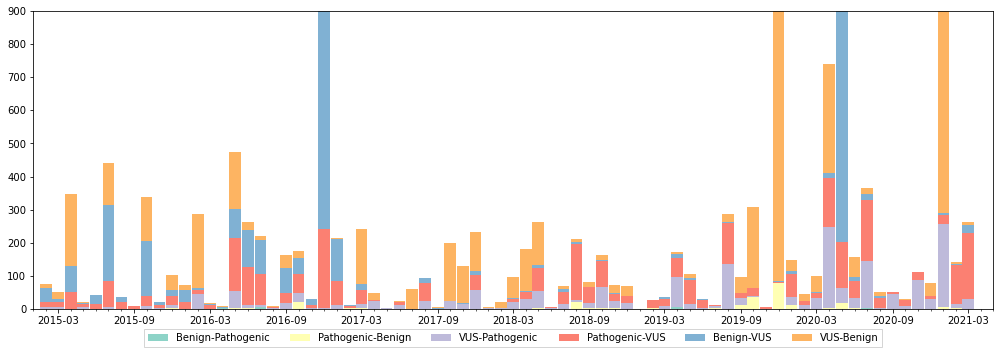

In [290]:
sns.set_palette(
sns.color_palette("Set3"))
plotChnages(allValuesNoConf,'ClinVarAbsChangesLim') #absolute


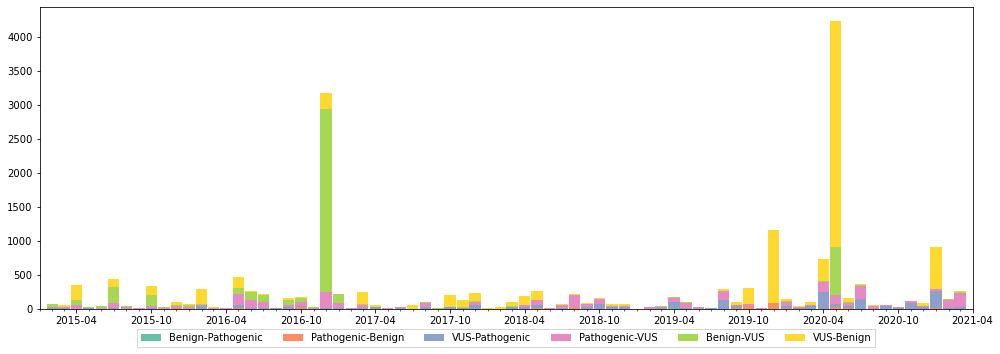

In [216]:
plotChnages(allValuesNoConf,'Absolute changes in the labels with respect to the previous month in ClinVar dataset') #absolute


In [136]:
#plotChnages(allValues,'Delta of CS wrt to the previous month') #absolute

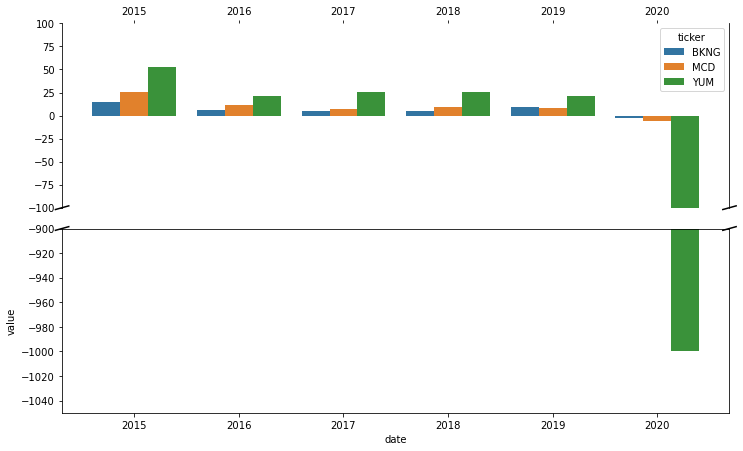

In [149]:
import seaborn as sns
dict_ = {'date': [pd.Timestamp('20150720'),pd.Timestamp('20160720'),pd.Timestamp('20170720'),pd.Timestamp('20180720'),pd.Timestamp('20190720'),pd.Timestamp('20200720')],
            'BKNG': [15.22, 6.36, 5.05, 5, 9.3641, -3],
            'MCD' : [25.22, 11.36, 7.05, 9, 8.3641, -6],
            'YUM' : [52.22, 21.36, 25.05, 26, 21.3641, -1000]
    
}

df = pd.DataFrame(dict_)
df['date'] = df['date'].dt.year

df = df.set_index('date').stack().reset_index()
df.columns = ['date','ticker','value']


f, ax = plt.subplots(2, 1, sharex=True, figsize=(10,6))
f.tight_layout()
# plot the same data on both axes
sns.barplot(x='date',y='value',hue='ticker',data=df, ax=ax[0], )
ax[0].set_ylim(-100,100)
sns.barplot(x='date',y='value',hue='ticker',data=df, ax=ax[1])
ax[1].set_ylim(-1050,-900)

ax[0].spines['bottom'].set_visible(False)
ax[0].set(xlabel='', ylabel='')
ax[0].spines['top'].set_visible(False)
ax[0].xaxis.tick_top()
ax[0].tick_params(labeltop='off')  # don't put tick labels at the top
ax[1].xaxis.tick_bottom()
ax[1].legend([],[], frameon=False)
d = .01  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax[0].transAxes, color='k', clip_on=False)
ax[0].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax[0].plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax[1].transAxes)  # switch to the bottom axes
ax[1].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax[1].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'

plt.show()

In [226]:
def plotChnages(count, title,width = 30,ncol = 6):

    fig, ax = plt.subplots(2, 1, sharex=True,figsize=(14,10))  
    fig.tight_layout()

    N = count.shape[1]
    width = 0.35
    #r = list(range(count.shape[1]))
   # display(count)
    r = pd.to_datetime(count.columns)
    rest = []
    ax[1].set_ylim(0,700)
    ax[0].set_ylim(1100,1200)
    for i in count.index[:]:
        ax[1].bar(r, count[count.index==i].values.squeeze(),bottom = count[count.index.isin(rest)].sum().values,
               width=27,label = i )
        rest.append(i)
        
    for i in count.index[:]:
        ax[0].bar(r, count[count.index==i].values.squeeze(),bottom = count[count.index.isin(rest)].sum().values,
               width=27,label = i )
        rest.append(i)


    fmt_half_year = mdates.MonthLocator(interval=6)
    ax[0].xaxis.set_major_locator(fmt_half_year)
    fmt_month = mdates.MonthLocator()
    ax[0].xaxis.set_minor_locator(fmt_month)

    ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax[0].format_xdata = mdates.DateFormatter('%Y-%m')
    ax[0].format_ydata = lambda x: f'${x:.2f}'  # Format the price.
    #plt.title(label = title)
    ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=False, shadow=False, ncol=ncol)   
    ax[0].legend([],[], frameon=False)
    d = .001  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax[0].transAxes, color='k', clip_on=False)
   

    kwargs.update(transform=ax[1].transAxes)  # switch to the bottom axes
    ax[0].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax[0].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
    ax[1].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax[1].plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

   # plt.ylim(0, 250)
 #   plt.yscale('log')
  
    plt.tight_layout()
     #   plt.savefig('figures/'+ title + '.png', dpi = 350)
    plt.show()

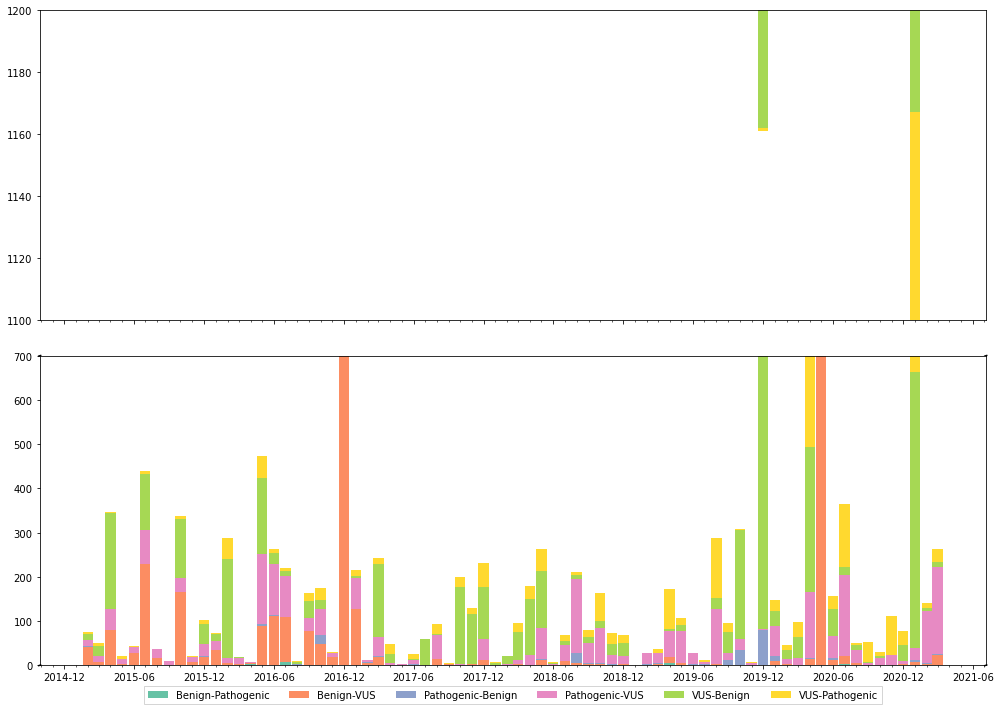

In [227]:
plotChnages(allValuesNoConf,'Absolute changes in the labels with respect to the previous month in ClinVar dataset') #absolute




In [ ]:
len(allValuesSample)
allCountSample

In [ ]:
plotChnages(allValuesRel,'Delta of CS wrt to the previous month',35) #relative

In [ ]:
plotChnages(allValuesSampleRel,'Delta of CS wrt to the previous month',35) #relative

In [ ]:
plotChnages(count,'Value count of CF per month',30,ncol=4)

In [ ]:
plotChnages(countSample,'Value count of CF per month',30,ncol=4)

In [ ]:
countSample.iloc[:,0]

In [ ]:
countSample.iloc[:,-1]

In [ ]:
#figure = plt.sublots()

#pd.Series(sing).plot(kind = 'bar',figsize = (10,7),stacked=False,colormap = 'viridis')

#### Quantife the CS

In [ ]:
to_replace = {'Uncertain significance': 0, 
              'Pathogenic': -1, 
              'Likely benign': 0.5, 
              'Benign': 1, 
              'Benign/Likely benign' : 0.75, 
              'Likely pathogenic' : -0.5, 
              'Pathogenic/Likely pathogenic' : -0.75}

ff = f.apply(lambda x: x.replace(to_replace))

In [ ]:
changed = []
for i in range(11):
    #c = (f[i]!=f[i+1]).sum()
    c = ((abs(ff[i]-ff[i+1]))>=0.5).sum()
    changed.append(c)

### Aside (use vcf files of ClinVar)

In [ ]:
import vcf 
import allel


In [ ]:
reader = vcf.Reader(open('dataRaw/clinvar_20150106.vcf', 'r'))

formats = reader.formats.keys()
infos = reader.infos.keys()
formats

In [ ]:
infos